# First Experiment with MCF7 cell line Smartseq Technology

Import libraries.

In [8]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             
import seaborn as sns  
import pandas as pd



Get the metadata

In [ ]:
mt_MCF7SS = pd.read_csv("",delimiter="\t",engine='python',index_col=0)


In [ ]:
print("Dataframe dimensions:", np.shape(mt_MCF7SS))
print("First column: ", mt_MCF7SS.iloc[ : , 0])

In [ ]:
mt_MCF7SS.head()

### Meaning of the metadata

Rows encode the information that we have on the columns for that sample.

Cell Line:
The biological cell line used in the experiment. Here we have MCF7, a breast cancer cell line.

Lane:
A reference to the sequencing lane or group (output.STAR.1), probably a technical replicate or batch.

Pos:
Sample position or plate coordinate.

Condition:
The experimental condition applied:

Hypo: Hypoxia (low oxygen).

Norm: Normoxia (normal oxygen levels).

Hours:
The duration of the treatment in hourS, here, 72 hours.

Cell name:
Sample ID.

PreprocessingTag:
Indicates how the BAM file was processed prior to analysis. Here, all files are Aligned.sortedByCoord.out.bam, meaning the reads were aligned and sorted by genomic coordinates.

ProcessingComments:
Notes on the software/tools used:

STAR: The aligner used for mapping reads.

FeatureCounts: The tool used for quantifying gene expression from the BAM files.



## Unfiltered data

In [ ]:
unf_MCF7SS= pd.read_csv("",delim_whitespace=True, index_col=0)
print("Dataframe dimensions:", np.shape(unf_MCF7SS))
print("First column: ", unf_MCF7SS.iloc[ : , 0])

In [ ]:
unf_MCF7SS.head()

Rows are symbols to identify genes, columns are our samples with information encoded in their name. Data shows ...

In [ ]:
list(unf_MCF7SS.columns)

In [ ]:
gene_symbols = unf_MCF7SS.index
print("Dataframe indexes: ", gene_symbols)

# Exploratory data analysis

In [ ]:
np.shape(unf_MCF7SS)

(22934, 383)

In [ ]:
unf_MCF7SS.dtypes

All data is numerical.

In [ ]:
X= unf_MCF7SS.to_numpy()
X


In [ ]:
print(unf_MCF7SS.isnull().sum())

There is no missing values.

In [ ]:
unf_MCF7SS.describe()

In [ ]:
cnames = list(unf_MCF7SS.columns)
cnames[1]
sns.boxplot(x=unf_MCF7SS[cnames[1]])

virtually every feature has zero counts (the entire box and whiskers sit at zero), and only a handful of features register any reads

In [ ]:
sns.violinplot(x=unf_MCF7SS[cnames[1]])

The little white dot (median) sits at zero and the thick black bar (IQR) is essentially collapsed there, showing that nearly all data points are zeros and only a handful of features register any reads at all.

In [ ]:
gene_stats = pd.DataFrame(index=unf_MCF7SS.index)  
gene_stats['mean'] = unf_MCF7SS.mean(axis=1)
gene_stats['std'] = unf_MCF7SS.std(axis=1)
gene_stats['min'] = unf_MCF7SS.min(axis=1)
gene_stats['max'] = unf_MCF7SS.max(axis=1)
gene_stats['zero_fraction'] = (unf_MCF7SS == 0).sum(axis=1) / unf_MCF7SS.shape[1]


In [ ]:
gene_stats['mean'].hist(bins=50)
plt.title("Histogram of Mean Gene Expression")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Genes")
plt.show()

Almost every gene has a very low average expression

In [ ]:
unf_MCF7SS.boxplot(figsize=(12, 6), showfliers=False)
plt.title("Expression Distribution per Sample")
plt.xlabel("Sample")
plt.ylabel("Counts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Almost every sample has the same basic pattern—most genes aren’t expressed, and only a few show moderate counts

Since our data is big, we will look at the most expressed genes.

In [ ]:
top_variable_genes = gene_stats['std'].sort_values(ascending=False).head(50).index
df_filtered = unf_MCF7SS.loc[top_variable_genes]


In [ ]:
import matplotlib.pyplot as plt

df_filtered.T.boxplot(showfliers=False, figsize=(14, 6))
plt.title("Expression Distribution per Sample (Top 50 Genes)")
plt.ylabel("Counts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import numpy as np

top_50 = df_filtered.var(axis=1).sort_values(ascending=False).head(50).index
top_50_data = df_filtered.loc[top_50]

zscore_data = (top_50_data - top_50_data.mean(axis=1).values[:, None]) / top_50_data.std(axis=1).values[:, None]

plt.figure(figsize=(12, 10))
sns.heatmap(zscore_data, cmap='viridis', xticklabels=False)
plt.title("Heatmap: Top 50 Most Variable Genes")
plt.show()


In [ ]:
sample_stats = pd.DataFrame(index=unf_MCF7SS.columns)  # Use sample names as index
sample_stats['mean'] = unf_MCF7SS.mean(axis=0)
sample_stats['std'] = unf_MCF7SS.std(axis=0)
sample_stats['min'] = unf_MCF7SS.min(axis=0)
sample_stats['max'] = unf_MCF7SS.max(axis=0)
sample_stats['zero_fraction'] = (unf_MCF7SS == 0).sum(axis=0) / unf_MCF7SS.shape[0]

In [ ]:
top_variable_samples = sample_stats['std'].sort_values(ascending=False).head(50).index
df_small = unf_MCF7SS[top_variable_samples]


In [ ]:

np.shape(df_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:
gene_stats['variance'] = unf_MCF7SS.var(axis=1)

plt.scatter(gene_stats['mean'], gene_stats['variance'], alpha=0.5, s=10)
plt.title("Mean vs Variance of Gene Expression")
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


### Outliers and Sparsity

In [ ]:
Q1 = unf_MCF7SS.quantile(0.25)
Q3 = unf_MCF7SS.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
df_noOut = unf_MCF7SS[~((unf_MCF7SS < (Q1 - 1.5 * IQR)) |(unf_MCF7SS > (Q3 + 1.5 * IQR))).any(axis=1)]
df_noOut.shape
df_noOut.head(5)

In [ ]:
sns.boxplot(x=df_noOut[cnames[1]])


In [ ]:
df_noOut_small = unf_MCF7SS.iloc[:, :50]
np.shape(df_noOut_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_noOut_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

Look at the sparsity percentege of the data.

In [ ]:
total_values = unf_MCF7SS.size

zero_values = (unf_MCF7SS == 0).sum().sum()

sparsity = zero_values / total_values
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 60.22%


### Distribution of the Data

In [ ]:
from scipy.stats import kurtosis, skew
colN = np.shape(unf_MCF7SS)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = unf_MCF7SS[cnames[i]]
     df_skew_cells += [skew(v_df)]   
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - original df')

In [ ]:
df_kurt_cells = []
for i in range(colN) :     
     v_df = unf_MCF7SS[cnames[i]]
     df_kurt_cells += [kurtosis(v_df)]   
df_kurt_cells
sns.histplot(df_kurt_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - original df')

### Data Transformation

In [ ]:
df1 = unf_MCF7SS + 1
df1_log2 = df1.apply(np.log2)
df1_log2_small = df1_log2.iloc[:, :50]
np.shape(df1_log2_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df1_log2_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:
df1_log2_skew_cells = []
for i in range(colN) :     
     v_df = df1_log2[cnames[i]]
     df1_log2_skew_cells += [skew(v_df)]   
df1_log2_skew_cells
sns.histplot(df1_log2_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - log2 df')

In [ ]:
df1_log2_kurt_cells = []
for i in range(colN) :     
     v_df = df1_log2[cnames[i]]
     df1_log2_kurt_cells += [kurtosis(v_df)] 
df1_log2_kurt_cells
sns.histplot(df1_log2_kurt_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - log2 df')

If we are satisfied

In [ ]:
unf_MCF7SS = df1_log2

In [ ]:
df_small = unf_MCF7SS.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
sns.displot(data=df_small,palette="Set3",kind="kde", bw_adjust=2)

Most values are concentrated near 0, suggesting lots of zero or low counts.

Distributions differ across cells, with some curves showing clear peaks while others are flat or skewed.

The yellow curve is extremely peaked at 0 — this suggests a highly sparse cell, with many genes not expressed at all.

Log-transformation reduces the influence of highly expressed genes and helps bring the distribution closer to normal.

We try another technique to see if we can get better graphs. 

In [ ]:
cpm = unf_MCF7SS.div(unf_MCF7SS.sum(axis=0), axis=1) * 1e6


In [ ]:
log_cpm = np.log2(cpm + 1)

In [ ]:
df_small = log_cpm.iloc[:, 10:30] 
sns.displot(data=df_small,palette="Set3",kind="kde", bw_adjust=2)

it's much improved compared to the earlier one. Most cells now have similarly shaped distributions, indicating successful normalization.
Distributions are centered and compressed, as expected after log-transformation and CPM normalization.
However, there's one yellow spike near 0, much taller than the others — this suggests one cell has a disproportionately high number of zero or very low expression values.

In [ ]:

zero_counts_per_cell = (unf_MCF7SS == 0).sum()

zero_log_counts = (log_cpm == 0).sum()

print(zero_log_counts.sort_values(ascending=False).head())


Let's further look at one of the genes in this list.

In [ ]:
cell_name = zero_log_counts.idxmax()
log_cpm[cell_name].plot(kind='hist', bins=50, title=f'Expression for {cell_name}')

We see that it has only zero counts. We can eliminate these genes in our data set.

## Duplicates

In [ ]:
duplicate_rows_df = unf_MCF7SS[unf_MCF7SS.duplicated(keep=False)]
print("number of duplicate rows: ", duplicate_rows_df.shape)
print("number of duplicate rows: ", duplicate_rows_df)

In [ ]:
print("names of duplicate rows: ",duplicate_rows_df.index)
duplicate_rows_df_t = duplicate_rows_df.T
duplicate_rows_df_t
c_dupl = duplicate_rows_df_t.corr()
c_dupl

In [ ]:
duplicate_rows_df_t.describe()

We group the duplicates.

In [ ]:
grouped = duplicate_rows_df.groupby(list(unf_MCF7SS.columns))

for name, group in grouped:
    print("Duplicate group:\n", group.index.tolist())

We log the duplicates genes that we eliminated to a csv file.

In [ ]:

dup_groups = grouped.groups.values()
genes_to_drop = [genes[1:] for genes in dup_groups if len(genes) > 1]
flat_genes_to_drop = [gene for sublist in genes_to_drop for gene in sublist]

import pandas as pd
pd.Series(flat_genes_to_drop).to_csv("dropped_duplicate_genes.csv", index=False)


df_log_nodup = unf_MCF7SS.drop(index=flat_genes_to_drop)


In [ ]:
unf_MCF7SS = df_log_nodup

In [ ]:
unf_MCF7SS.count()

## Filtered

In [ ]:
f_MCF7SS = pd.read_csv("SmartSeq/MCF7_SmartS_Filtered_Data.txt",delim_whitespace=True, index_col=0)

In [ ]:
f_MCF7SS.shape

(18945, 313)

In [ ]:
fnames = list(f_MCF7SS.columns)
fnames[1]
sns.boxplot(x=f_MCF7SS[fnames[1]])

In [ ]:
col = np.shape(f_MCF7SS)[1]
col
df_cells = []
for i in range(col) :     
     f_df = f_MCF7SS[fnames[i]]
     df_cells += [skew(f_df)]   
df_cells
sns.histplot(df_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - filtered data')

In [ ]:
df_k_cells = []
for i in range(col) :     
     f_df = f_MCF7SS[fnames[i]]
     df_k_cells += [kurtosis(f_df)] 
df_k_cells
sns.histplot(df_k_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - filtered data')

In [ ]:
f_small = f_MCF7SS.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
sns.displot(data=f_small,palette="Set3",kind="kde", bw_adjust=2)

## Normalized

In [ ]:
n_MCF7SS = pd.read_csv("",delim_whitespace=True, index_col=0)

In [ ]:
n_MCF7SS.shape

(3000, 250)

In [ ]:
n_MCF7SS.head()

In [ ]:
nnames = list(n_MCF7SS.columns)
nnames[1]
sns.boxplot(x=n_MCF7SS[nnames[1]])

In [ ]:
ncol = np.shape(n_MCF7SS)[1]
ncol
dn_cells = []
for i in range(ncol) :     
     n_df = n_MCF7SS[nnames[i]]
     dn_cells += [skew(n_df)]   
dn_cells
sns.histplot(dn_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - normalized data')

In [ ]:
df_n_cells = []
for i in range(ncol) :     
     n_df = n_MCF7SS[nnames[i]]
     df_n_cells += [kurtosis(n_df)] 
df_n_cells
sns.histplot(df_n_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - normalized data')

In [ ]:
n_small = n_MCF7SS.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
sns.displot(data=n_small,palette="Set3",kind="kde", bw_adjust=2)

# Correlations

In [ ]:
cell_corr = unf_MCF7SS.corr() 

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cell_corr, cmap="coolwarm", center=0)
plt.title("Cell-Cell Correlation Matrix")
midpoint = (cell_corr.values.max() - cell_corr.values.min()) /2 + cell_corr.values.min()
print("Number of cells included: ", np.shape(cell_corr))
print("Average correlation of expression profiles between cells: ", midpoint)
print("Min. correlation of expression profiles between cells: ", cell_corr.values.min())

Most cells are strongly correlated, with correlation values mostly > 0.7.
There are some white horizantel and vertical lines suggesting that the sample is low correlated with others.

In [ ]:
mean_corr = cell_corr.mean()
low_corr_cells = mean_corr[mean_corr < 0.7]  
print("Low correlation cells:", low_corr_cells.index.tolist())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cell in low_corr_cells.index[:5]:  
    plt.figure(figsize=(8,4))
    sns.histplot(unf_MCF7SS[cell], bins=50, kde=True)
    plt.title(f"Gene Expression Distribution - {cell}")
    plt.xlabel("Expression Level")
    plt.ylabel("Gene Count")
    plt.show()


In [ ]:
top_genes = unf_MCF7SS.var(axis=1).sort_values(ascending=False).head(50).index
gene_corr = unf_MCF7SS.loc[top_genes].T.corr()


In [ ]:
sns.heatmap(gene_corr, cmap="coolwarm", center=0)
plt.title("Gene–Gene Correlation (Top 50 Most Variable Genes)")


In [ ]:
np.shape(cell_corr)
type(cell_corr)
cell_corr.head(3)
c_small=cell_corr.iloc[:,:3]
sns.histplot(c_small,bins=100)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')

# PCA and Clustering

In [ ]:
nf_train =pd.read_csv("",delim_whitespace=True, index_col=0)

In [11]:
nf_train.shape


(3000, 250)

In [ ]:
nf_train.head()

In [13]:
nf_train=nf_train.T

In [14]:
nf_train.shape

(250, 3000)

We will first try to choose the components of PCA by the ratio of the variance we want to preserve.

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(nf_train)
pca.n_components_, pca.explained_variance_ratio_.sum()

(20, 0.951441753570086)

In [29]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by component:", explained_variance_ratio)

cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative explained variance:", cumulative_variance)


Explained variance ratio by component: [0.6344835  0.09107496 0.06270155 0.04033215 0.03156572 0.01538185
 0.01138705 0.01009336 0.00898676 0.00758287 0.00614321 0.00492391
 0.00467293 0.00430685 0.00377886 0.00331298 0.00300167 0.0027689
 0.00266241 0.00228027]
Cumulative explained variance: [0.6344835  0.72555846 0.78826001 0.82859216 0.86015788 0.87553973
 0.88692678 0.89702014 0.9060069  0.91358977 0.91973298 0.92465689
 0.92932982 0.93363667 0.93741553 0.94072851 0.94373018 0.94649908
 0.94916148 0.95144175]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
pca.fit(nf_train)  

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(nf_train)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
import pandas as pd

loading_scores = pd.Series(pca.components_[0], index=nf_train.columns)
top_genes_pc1 = loading_scores.abs().sort_values(ascending=False).head(10)

print("Top contributing genes to PC1:")
print(top_genes_pc1)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_gene_names = top_genes_pc1.index.tolist()
plt.figure(figsize=(12, 6))
sns.boxplot(data=nf_train[top_gene_names])
plt.title("Expression of Top Contributing Genes to PC1")
plt.xticks(rotation=45)
plt.ylabel("Expression Level")
plt.show()


These genes are the top contributors to the first principal component of our PCA analysis. With 0.704, GAPDH has high contribution. After some research, we found that GAPDH is a housekeeping gene that plays crucial role in glycolysis, a key process in energy production. ACTG1 encodes the structural protein actin. And ALDOA, also part of glycolysis; important in energy metabolism. Upregulated in hypoxic or cancerous conditions.

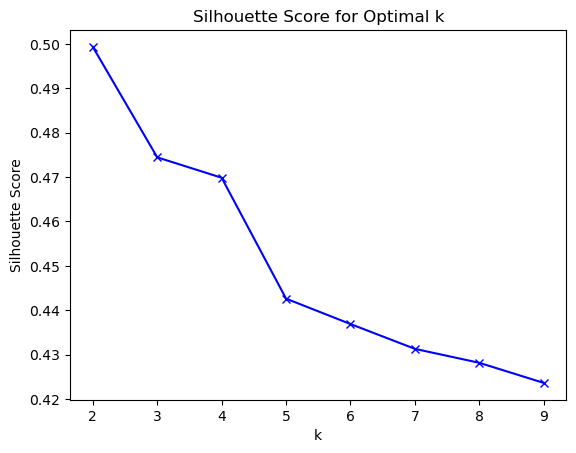

In [33]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(pca_result)
    sil.append(silhouette_score(pca_result, kmeans.labels_))

plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


Silhouette Score shows that the best number we can part the data is 2.

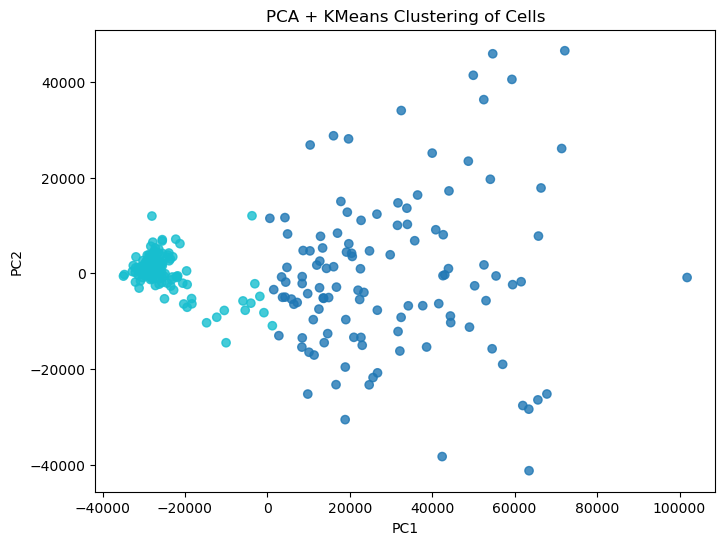

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(pca_result)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='tab10', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA + KMeans Clustering of Cells')
plt.show()


In [35]:
labels = kmeans.labels_
labels

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0], dtype=int32)

In [36]:
nf_train['cluster'] = labels


In [ ]:
nf_train.head()

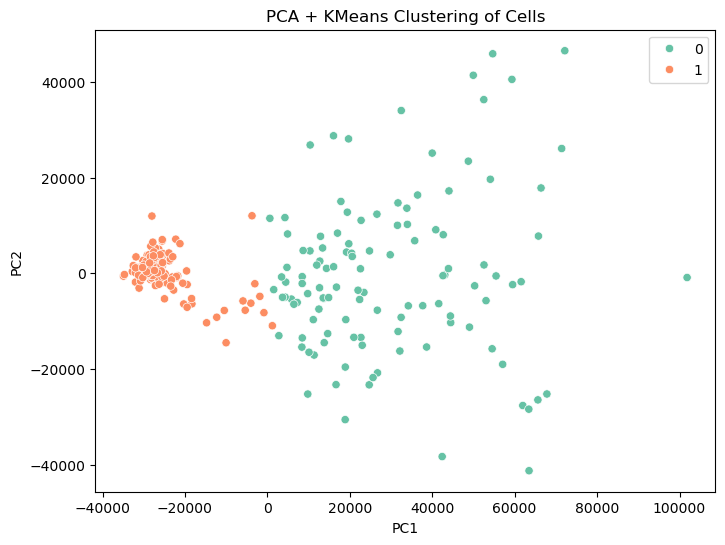

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set2')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA + KMeans Clustering of Cells")
plt.show()


In [ ]:
cell_names = nf_train[nf_train['cluster'] == 0].index.tolist()
cell_names

We see that clustring parts the data as Hypo and Normo.

# Supervised learning

In [ ]:
nf_test =pd.read_csv("",delim_whitespace=True, index_col=0)

In [41]:
nf_test.shape

(3000, 63)

In [ ]:
nf_test.head()

In [ ]:
nf_train.head()

In [44]:
nf_train.drop("cluster", axis=1, inplace=True)

In [45]:
sample_names_train =nf_train.index

label_train=np.array([1 if "Hypo" in name else 0 for name in sample_names_train])
print(pd.Series(label_train, index=sample_names_train).value_counts())


0    126
1    124
Name: count, dtype: int64


Let's see if we have cells with too many zeros inorder to further reduce the data set.

In [46]:
cell_threshold = 0.1 

non_zero_fraction_genes = (nf_train != 0).sum(axis=1) / nf_train.shape[1]

df_filtered_genes = nf_train[non_zero_fraction_genes >= cell_threshold]

In [47]:
df_filtered_genes.shape

(250, 3000)

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
df_pca = pca.fit_transform(nf_train)


In [49]:
def calculate_sparsity(data):
    total_values = data.size
    zero_values = (data == 0).sum().sum()
    return zero_values / total_values

print("Original sparsity:", calculate_sparsity(nf_train))
print("Filtered sparsity:", calculate_sparsity(df_pca))

Original sparsity: 0.6362213333333333
Filtered sparsity: 0.0


### Model Selection

We will try different classifiers to find the most suitable one. Since our data is simple binary labeling, we can suspect that Logistic Regression will give a good score.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}


In [52]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=20)),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, nf_train, label_train, cv=5)
    results[name] = scores.mean()
    print(f"{name}: CV accuracy = {scores.mean():.4f}")
    print(f"{name}: Training accuracy = {pipe.fit(nf_train, label_train).score(nf_train, label_train):.4f}")
    



Logistic Regression: CV accuracy = 1.0000
Logistic Regression: Training accuracy = 1.0000
Random Forest: CV accuracy = 0.9840
Random Forest: Training accuracy = 1.0000
SVM: CV accuracy = 0.9960
SVM: Training accuracy = 1.0000
Naive Bayes: CV accuracy = 0.9520
Naive Bayes: Training accuracy = 0.9520
KNN: CV accuracy = 0.9880
KNN: Training accuracy = 0.9960
Decision Tree: CV accuracy = 0.9720
Decision Tree: Training accuracy = 1.0000


In [53]:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for name, score in sorted_results:
    print(f"{name:<20}  CV Accuracy: {score:.4f}")


Logistic Regression   CV Accuracy: 1.0000
SVM                   CV Accuracy: 0.9960
KNN                   CV Accuracy: 0.9880
Random Forest         CV Accuracy: 0.9840
Decision Tree         CV Accuracy: 0.9720
Naive Bayes           CV Accuracy: 0.9520


Random Forets and Logistic Regression models give better accuracy scores than others, however they also indicate over-fitting. Now we will perform randomized search to tune best-performing models in order to solve this problem. 

We will use RandomizedSearchCV to find the best hyperparameters for the Logistic Regression model.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

pipe = Pipeline([
    ("scale",  StandardScaler()),        
    ("pca",    PCA(n_components=20)),      
    ("clf",    LogisticRegression(
                   max_iter=1000,
                   solver="liblinear"))
                
])
param_distributions = {
    "clf__C": loguniform(1e-3, 1e3)
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    random_state=42,
    verbose=1
)

search.fit(nf_train, label_train)

print("Best CV accuracy:", search.best_score_)
print ("Training accuracy:", search.score(nf_train, label_train))
print("Best parameters:", search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 1.0
Training accuracy: 1.0
Best parameters: {'clf__C': 0.1767016940294795}


However, since the optimal number of principal components can vary depending on the algorithm used, we will determine the most suitable components specifically for the Logistic Regression model.

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import numpy as np

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA()),
    ("clf", LogisticRegression(max_iter=1000, solver='liblinear'))
])

param_distributions = {
    "pca__n_components": np.arange(10, 100),
    "clf__C": loguniform(1e-3, 1e3)
}

search_lr = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    random_state=42,
    verbose=1
)

search_lr.fit(nf_train, label_train)

print("Best CV accuracy:", search_lr.best_score_)
print ("Training accuracy:", search_lr.score(nf_train, label_train))
print("Best parameters:", search_lr.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 1.0
Training accuracy: 1.0
Best parameters: {'clf__C': 0.1767016940294795, 'pca__n_components': 24}


We will do the same process for Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np


pipe_rf = Pipeline([
    ("scale", StandardScaler()),    
    ("pca", PCA()),
    ("clf", RandomForestClassifier(random_state=42))
])


param_dist = {
    "pca__n_components": np.arange(10, 100),  
    "clf__n_estimators": [50, 100, 200, 300],
    "clf__max_depth": [None, 10, 20, 30, 40],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1
)
search_rf.fit(nf_train, label_train)

print("Best CV accuracy:", search_rf.best_score_)
print ("Training accuracy:", search.score(nf_train, label_train))
print("Best parameters:", search_rf.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 0.9879999999999999
Training accuracy: 1.0
Best parameters: {'pca__n_components': 55, 'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_depth': 40}


## Prediction

Our model with Random Forest.

In [58]:
model_rf = search_rf.best_estimator_
print("Best model:", model_rf)

Best model: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=55)),
                ('clf',
                 RandomForestClassifier(max_depth=40, min_samples_leaf=4,
                                        min_samples_split=5, n_estimators=300,
                                        random_state=42))])


Our model with Logistic regression. 

In [59]:
model_lr = search_lr.best_estimator_
print("Best model:", model_lr)

Best model: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=24)),
                ('clf',
                 LogisticRegression(C=0.1767016940294795, max_iter=1000,
                                    solver='liblinear'))])


In [ ]:
label_predict_rf= model_rf.predict(nf_test.T)
print("Predicted labels:", label_predict_rf[:10])
print("Predicted labels shape:", label_predict_rf.shape)

with open("MCF7_SmartSeq_predictions_rf.txt", "w") as f:
    for label in label_predict_rf:
        f.write(f"{label}\n")

In [ ]:
label_predict_lr = model_lr.predict(nf_test.T)
print("Predicted labels:", label_predict_lr[:10])
print("Predicted labels shape:", label_predict_lr.shape)

with open("MCF7_SmartSeq_predictions_lr.txt", "w") as f:
    for label in label_predict_lr:
        f.write(f"{label}\n")

Predicted labels: [1 1 0 0 0 0 0 1 1 0]
Predicted labels shape: (63,)


In [62]:
mask = label_predict_rf != label_predict_lr
print("Number of mismatches:", mask.sum())
mismatched_cells = nf_test.columns[mask]
print("Mismatched cells:", mismatched_cells.tolist())


Number of mismatches: 0
Mismatched cells: []


Their predictions are identical.

## Comparing with HCC1806

In [ ]:
HCC_train =pd.read_csv("",delim_whitespace=True, index_col=0)

In [64]:
HCC_train.shape

(3000, 182)

In [65]:
HCC_train=HCC_train.T

In [66]:
import numpy as np

sample_names_train = HCC_train.index

hcc_label = np.array([0 if "Hypo" in name else 1 for name in sample_names_train])

print(pd.Series(hcc_label, index=sample_names_train).value_counts())

0    97
1    85
Name: count, dtype: int64


Keeping the same parameteres

In [67]:
model_MCF = model_rf.fit(HCC_train, hcc_label)
print("Training accuracy:", model_MCF.score(HCC_train, hcc_label))


Training accuracy: 1.0


The model can also fit HCC1806

In [68]:
common_genes = nf_train.columns.intersection(HCC_train.columns)
X_train_aligned = nf_train[common_genes]
H_train_aligned = HCC_train[common_genes]


In [69]:
model_rf.fit(X_train_aligned, label_train)
acc = model_rf.score(H_train_aligned, hcc_label)
print(f"Accuracy on HCC using MCF-trained model: {acc:.4f}")


Accuracy on HCC using MCF-trained model: 0.4121


This tells that the decision boundary and variance structure learned on MCF7 cells do not generalize to HCC1806 cells. Hypoxia signatures in one cell line aren’t the same in the other.